# **Uber/Lyft Fare Prediction**

### This project predicts ride fares for Uber and Lyft rides based on historical ride data. The objective is to provide accurate predictions for fare prices, enabling insights into the factors influencing ride costs.

In [0]:
pip install torch


Python interpreter will be restarted.
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-871ec763-f684-411d-9008-5264548853f7
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
Python interpreter will be restarted.


In [0]:
pip install networkx

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install flask

Python interpreter will be restarted.
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-871ec763-f684-411d-9008-5264548853f7
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Not uninstalling jinja2 at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-871ec763-f684-411d-9008-5264548853f7
    Can't uninstall 'Jinja2'. No files were found to uninstall.
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Not uninstalling click at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-871ec763-f684-411d-9008-5264548853f7
    Can't uninstall 'click'. No files were found 

In [0]:
# Import necessary PySpark libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%md
## Kaggle Link: 
https://www.kaggle.com/datasets/brllrb/uber-and-lyft-dataset-boston-ma 

## Dataset Overview-
General Information
Rows: 693,071

Columns: 57


## Key Features
### Target/Predictor Variable:
**price**: Continuous variable representing the fare amount. Missing values to be handled during preprocessing.

### Input Features:
Temporal: hour, day, month, datetime (can extract weekday).
Categorical: cab_type, source, destination, name, timezone.
Numerical: distance, surge_multiplier, temperature, humidity, windSpeed.
Weather-Related: precipIntensity, cloudCover, uvIndex, visibility.
Other Notable Features:
Geospatial: latitude, longitude for pickup and dropoff.
Redundant: visibility.1 (duplicated column), id (identifier).

## The dataset includes the following key columns:

## **1. Ride Information**  
Describes the ride details such as ID, source, destination, and ride type.

- **id**: Unique identifier for each ride.  
- **source**: Starting location of the ride.  
- **destination**: End location of the ride.  
- **cab_type**: Type of service (e.g., Lyft or Uber).  
- **product_id**: Ride product identifier.  
- **name**: Ride product name (e.g., Shared, Lux).  
- **price**: Cost of the ride.  
- **distance**: Trip distance in miles or kilometers.  
- **surge_multiplier**: Surge pricing multiplier.  

---

## **2. Temporal Data**  
Includes time-related information about the ride and relevant timestamps.

- **timestamp**: Unix timestamp of the ride request.  
- **datetime**: Human-readable format of the timestamp.  
- **hour, day, month**: Decomposed time features for easier analysis.  
- **timezone**: Timezone for the ride.  
- **temperatureHighTime, temperatureLowTime**: Times for high and low temperatures.  
- **sunriseTime, sunsetTime**: Sunrise and sunset times.  
- **windGustTime, uvIndexTime**: Times for maximum wind gust and UV index.  

---

## **3. Weather Conditions**  
Provides data on weather during the ride.

- **temperature**: Actual temperature during the ride.  
- **apparentTemperature**: Feels-like temperature.  
- **short_summary**: Brief weather description (e.g., "Partly Cloudy").  
- **long_summary**: Detailed weather description.  
- **precipIntensity, precipProbability**: Intensity and likelihood of precipitation.  
- **humidity**: Relative humidity as a percentage.  
- **visibility**: Visibility distance.  
- **icon**: Weather condition icon (e.g., "rain").  
- **dewPoint**: Temperature at which dew forms.  
- **cloudCover**: Cloud coverage percentage.  
- **uvIndex**: UV index level.  
- **ozone**: Ozone level in the atmosphere.  
- **pressure**: Atmospheric pressure.  

---

## **4. Temperature Extremes**  
Records daily high and low temperatures, along with their "feels-like" counterparts.

- **temperatureHigh, temperatureLow**: Daily maximum and minimum temperatures.  
- **apparentTemperatureHigh, apparentTemperatureLow**: Feels-like max and min temperatures.  
- **temperatureMin, temperatureMax**: Minimum and maximum temperatures of the day.  
- **apparentTemperatureMin, apparentTemperatureMax**: Feels-like min and max temperatures.  

---

## **5. Wind Conditions**  
Provides wind-related data during the ride.

- **windSpeed**: Wind speed during the ride.  
- **windGust**: Maximum observed wind speed.  
- **windBearing**: Direction of the wind in degrees.  

---

## **6. Additional Context**  
Provides additional atmospheric and temporal context.

- **moonPhase**: Phase of the moon.  
- **precipIntensityMax**: Maximum intensity of precipitation.  
- **visibility**: Distance at which objects can be clearly seen.  

## Data Lineage
The dataset is sourced from Kaggle and includes ride data for Uber and Lyft with fields for timestamps, source/destination locations, and ride details such as surge multipliers and distances.


In [0]:
import matplotlib.pyplot as plt
import networkx as nx

# Define lineage relationships
lineage_graph = [
    ("Source: Kaggle --> Onedrive", "Transformation"),
    ("Transformation", "Feature Engineering"),
    ("Feature Engineering", "Filtering"),
    ("Filtering", "Destination")
]

# Create the graph
G = nx.DiGraph()
G.add_edges_from(lineage_graph)

# Draw the graph
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=10000, font_size=12, arrowsize=20)
plt.title("Data Lineage Flow")
plt.show()


In [0]:
%pip install onedrivedownloader
from onedrivedownloader import download

download_path = "https://mygsu-my.sharepoint.com/:u:/g/personal/skotian1_gsu_edu/EU2iYLZi-iRGuUd_DLMtyxwBMXgzQDfGbXG9BvJy91y96g?e=I2Tj2b"

download(download_path, filename="rideshare_kaggle.csv.zip", unzip=True, clean=True)

Python interpreter will be restarted.
Python interpreter will be restarted.


100%|██████████| 46.6M/46.6M [00:00<00:00, 64.5MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Out[3]: ''

In [0]:
data_directory = "file:/databricks/driver/rideshare_kaggle.csv"
spark_df = spark.read.csv(data_directory, header=True, inferSchema=True)
print("Data Loaded Successfully")

Data Loaded Successfully


In [0]:
spark_df.display()

#Checking for Outliers using Box-Plots

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Specify the columns for which you want to create box plots
boxplot_columns = [
    "price",
    "distance",
    "surge_multiplier",
    "temperature",
    "apparentTemperature",
    "humidity",
    "windSpeed",
    "visibility",
    "cloudCover",
    "temperatureMin",
    "temperatureMax"
]

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = spark_df.select(boxplot_columns).toPandas()

# Ensure columns are numeric and drop non-numeric or NaN values for plotting
pandas_df = pandas_df.apply(pd.to_numeric, errors="coerce")  # Convert non-numeric to NaN
pandas_df = pandas_df.dropna()  # Drop rows with NaN values

# Create box plots for each numeric column
for column in boxplot_columns:
    if pandas_df[column].dtype in ["float64", "int64"]:  # Ensure the column is numeric
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=pandas_df, y=column, color="skyblue")
        plt.title(f"Box Plot of {column}", fontsize=14)
        plt.ylabel(column, fontsize=12)
        plt.xlabel("Values", fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print(f"Skipping non-numeric column: {column}")


## Data Cleaning
- Converting the price column to a double (floating-point number) to ensure all values in this column are numeric and suitable for calculations
- Replacing missing values in price with the mean i.e. Imputation is done
- Removing the row with the maximum price as part of outlier removal
- Dropping rows with null values in specific columns


In [0]:
from pyspark.sql import functions as F
# Convert to appropriate types
spark_df = spark_df.withColumn("price", F.col("price").cast("double"))

mean_price = spark_df.agg(F.mean("price")).collect()[0][0]
spark_df = spark_df.na.fill({"price": mean_price})

# Step 3: Check the max value of price and delete that row
max_price_row = spark_df.agg(F.max("price")).collect()[0][0]
spark_df = spark_df.filter(spark_df["price"] != max_price_row)

# Drop rows where any relevant column is null (if necessary)
spark_df = spark_df.dropna(subset=['hour', 'month', 'source', 'destination', 'cab_type', 'name', 'price',
                    'distance', 'surge_multiplier', 'day'])

In [0]:
spark_df.display()

## Data Transformation
- Converting datetime to a Spark Timestamp for consistentcy
- Extracted day from the datetime column for better insights
- Converted categorical variables to one-hot encoding for modeling
- Adding a binary column of is_weekend to help identify differences in behavior between weekdays and weekends


In [0]:
# Convert datetime to timestamp and extract features
from pyspark.sql.functions import to_timestamp, dayofweek, when
spark_df = spark_df.withColumn("datetime", to_timestamp("datetime")) \
    .withColumn("day_of_week", dayofweek("datetime")) \
    .withColumn("is_weekend", when(dayofweek("datetime").isin([1, 7]), 1).otherwise(0))

In [0]:
# 2. Data Exploration
spark_df.printSchema()
spark_df.display()


In [0]:
import seaborn as sns
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame
#pandas_df = spark_df.toPandas()

# Use Seaborn to create the histogram
sns.set(style="whitegrid")  # Set the style for Seaborn
sns.histplot(data=spark_df.toPandas(), x='price', bins=50, kde=True, color="blue")

In [0]:
from pyspark.sql.types import NumericType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd

# Drop irrelevant columns and ensure unique names
columns_to_drop = ['id', 'datetime', 'timezone', 'visibility.1']  # Irrelevant columns
spark_df_clean = spark_df.drop(*columns_to_drop)

# Step 1: Ensure only numeric columns
numeric_cols = [col for col, dtype in spark_df_clean.dtypes if isinstance(spark_df_clean.schema[col].dataType, NumericType)]
print("Filtered numeric columns: ", numeric_cols)

# Step 2: Assemble features into a single vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_vector")
spark_df_vector = assembler.transform(spark_df_clean).select("features_vector")

# Step 3: Compute Correlation Matrix
correlation_matrix = Correlation.corr(spark_df_vector, "features_vector").head()[0].toArray()

# Step 4: Convert and Display using Pandas
corr_df = pd.DataFrame(correlation_matrix, index=numeric_cols, columns=numeric_cols)
print("Correlation Matrix:\n", corr_df)


Filtered numeric columns:  ['timestamp', 'hour', 'day', 'month', 'price', 'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature', 'apparentTemperature', 'precipIntensity', 'precipProbability', 'humidity', 'windSpeed', 'windGust', 'windGustTime', 'visibility', 'temperatureHigh', 'temperatureHighTime', 'temperatureLow', 'temperatureLowTime', 'apparentTemperatureHigh', 'apparentTemperatureHighTime', 'apparentTemperatureLow', 'apparentTemperatureLowTime', 'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase', 'precipIntensityMax', 'uvIndexTime', 'temperatureMin', 'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime', 'apparentTemperatureMin', 'apparentTemperatureMinTime', 'apparentTemperatureMax', 'apparentTemperatureMaxTime', 'day_of_week', 'is_weekend']
Correlation Matrix:
                              timestamp      hour       day     month  \
timestamp                     1.000000 -0.028006 -0.341294  0.

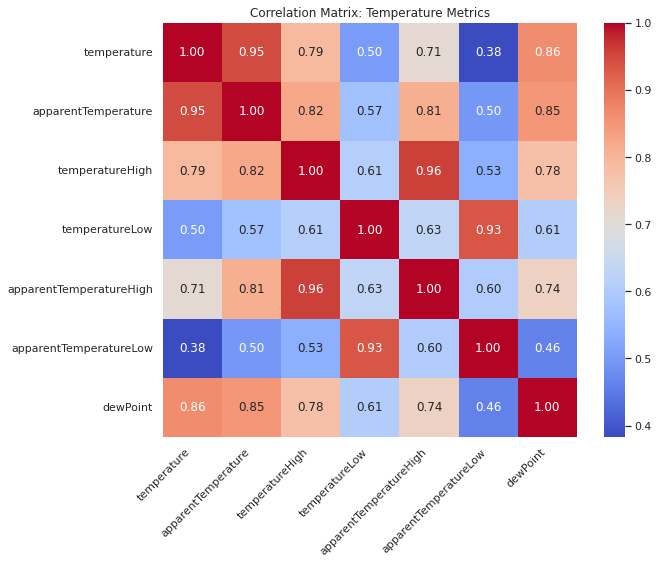

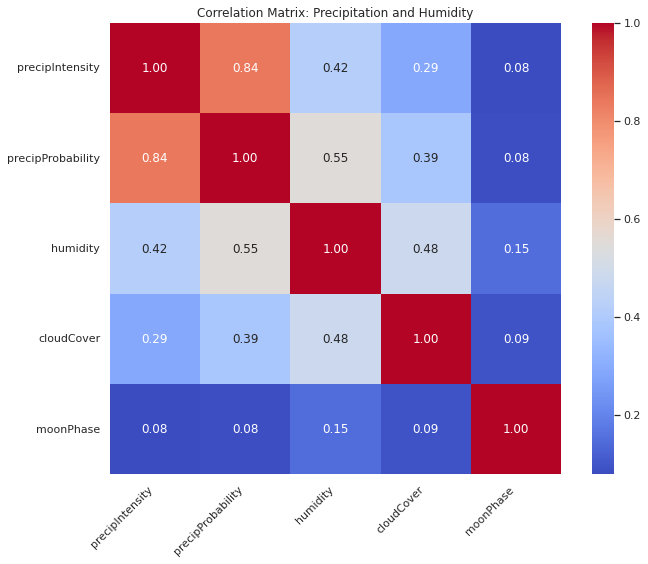

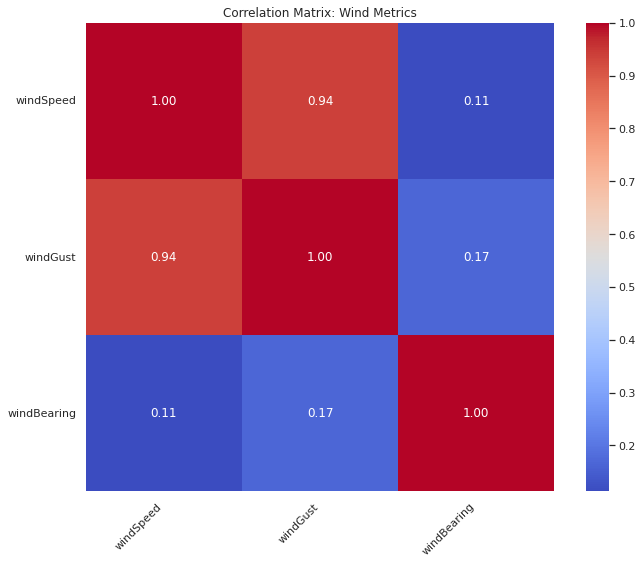

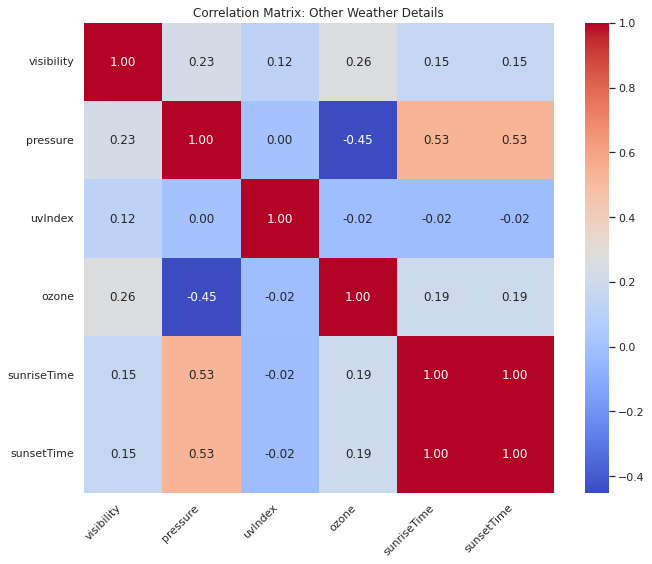

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group columns logically (updated to exclude timestamp and uvIndexTime)

trip_columns = ['price', 'distance', 'surge_multiplier', 'latitude', 'longitude']
temperature_columns = [
    'temperature', 'apparentTemperature', 'temperatureHigh', 'temperatureLow', 
    'apparentTemperatureHigh', 'apparentTemperatureLow', 'dewPoint'
]

precipitation_humidity_columns = [
    'precipIntensity', 'precipProbability', 'humidity', 'cloudCover', 'moonPhase'
]

wind_columns = ['windSpeed', 'windGust', 'windBearing']

other_weather_columns = ['visibility', 'pressure', 'uvIndex', 'ozone', 'sunriseTime', 'sunsetTime']

redundant_columns = ['visibility.1', 'icon']

# Function to plot heatmap for each group
def plot_group_heatmap(df, group_cols, title):
    valid_cols = [col for col in group_cols if col in df.columns]  # Ensure columns exist in the DataFrame
    if valid_cols:
        subset_corr = df.loc[valid_cols, valid_cols]
        plt.figure(figsize=(10, 8))
        sns.heatmap(subset_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
        plt.title(title)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

# Plot heatmaps for each group

plot_group_heatmap(corr_df, trip_columns, "Correlation Matrix: Trip and Pricing Information")
plot_group_heatmap(corr_df, temperature_columns, "Correlation Matrix: Temperature Metrics")
plot_group_heatmap(corr_df, precipitation_humidity_columns, "Correlation Matrix: Precipitation and Humidity")
plot_group_heatmap(corr_df, wind_columns, "Correlation Matrix: Wind Metrics")
plot_group_heatmap(corr_df, other_weather_columns, "Correlation Matrix: Other Weather Details")
plot_group_heatmap(corr_df, redundant_columns, "Correlation Matrix: Redundant Columns")


### Reasons for Dropping Unused Columns

1. **Redundancy with `datetime`:**
   - Columns: `timestamp`, `hour`, `day`, `month`
   - Reason: These are already encapsulated in the `datetime` column, making them redundant for analysis.

2. **Specific Identifiers/Metadata:**
   - Columns: `id`, `timezone`, `source`, `destination`, `product_id`, `name`
   - Reason: These columns provide granular details (e.g., unique identifiers, source/destination specifics) that are unnecessary when focusing on higher-level attributes like `distance` or `cab_type`.

3. **Irrelevant Weather Details:**
   - Columns: `precipIntensity`, `precipProbability`, `windGust`, `windGustTime`, `temperatureHigh`, `temperatureHighTime`, `temperatureLow`, `temperatureLowTime`, `apparentTemperatureHigh`, `apparentTemperatureHighTime`, `apparentTemperatureLow`, `apparentTemperatureLowTime`, `icon`, `dewPoint`, `pressure`, `windBearing`, `cloudCover`, `uvIndex`, `ozone`, `sunriseTime`, `sunsetTime`, `moonPhase`, `precipIntensityMax`, `uvIndexTime`, `temperatureMin`, `temperatureMinTime`, `temperatureMax`, `temperatureMaxTime`, `apparentTemperatureMin`, `apparentTemperatureMinTime`, `apparentTemperatureMax`, `apparentTemperatureMaxTime`
   - Reason: These columns detail fine-grained or extreme weather conditions that may not meaningfully affect high-level cab pricing and distance analysis.

4. **Duplicate/Unnecessary Metrics:**
   - Columns: `visibility.1`
   - Reason: This duplicates the `visibility` column and offers no added value.


In [0]:

spark_df = spark_df.select('hour', 'month', 'source', 'destination', 'cab_type', 'name', 'price',
                    'distance', 'surge_multiplier', 'day', 'is_weekend')

In [0]:
spark_df.display()

hour month source destination cab_type name price distance surge_multiplier day is_weekend 9 12 Haymarket Square North Station Lyft Shared 5.0 0.44 1.0 16 1 2 11 Haymarket Square North Station Lyft Lux 11.0 0.44 1.0 27 0 1 11 Haymarket Square North Station Lyft Lyft 7.0 0.44 1.0 28 0 4 11 Haymarket Square North Station Lyft Lux Black XL 26.0 0.44 1.0 30 0 3 11 Haymarket Square North Station Lyft Lyft XL 9.0 0.44 1.0 29 0 18 12 Haymarket Square North Station Lyft Lux Black 16.5 0.44 1.0 17 0 5 11 Back Bay Northeastern University Lyft Lyft XL 10.5 1.08 1.0 26 0 19 12 Back Bay Northeastern University Lyft Lux Black 16.5 1.08 1.0 2 1 6 12 Back Bay Northeastern University Lyft Shared 3.0 1.08 1.0 3 0 10 11 Back Bay Northeastern University Lyft Lux Black XL 27.5 1.08 1.0 27 0 16 11 Back Bay Northeastern University Lyft Lux 13.5 1.08 1.0 30 0 19 11 Back Bay Northeastern University Lyft Lyft 7.0 1.08 1.0 28 0 22 11 North End West End Uber UberXL 12.0 1.11 1.0 30 0 10 12 North End West End Uber Black 16.0 1.11 1.0 13 0 19 12 North End West End Uber UberX 7.5 1.11 1.0 13 0 23 12 North End West End Uber WAV 7.5 1.11 1.0 16 1 0 12 North End West End Uber Black SUV 26.0 1.11 1.0 14 0 19 11 North End West End Uber UberPool 5.5 1.11 1.0 29 0 14 12 North End West End Uber Taxi 16.54512549061407 1.11 1.0 1 1 6 12 North Station Haymarket Square Lyft Lyft XL 11.0 0.72 1.0 16 1 19 11 North Station Haymarket Square Lyft Lux Black 16.5 0.72 1.0 27 0 11 12 North Station Haymarket Square Lyft Lyft 7.0 0.72 1.0 18 0 2 11 North Station Haymarket Square Lyft Shared 3.5 0.72 1.0 30 0 16 12 North Station Haymarket Square Lyft Lux Black XL 26.0 0.72 1.0 16 1 7 11 North Station Haymarket Square Lyft Lux 13.5 0.72 1.0 26 0 20 12 Beacon Hill South Station Uber WAV 8.5 2.48 1.0 17 0 3 12 Beacon Hill South Station Uber UberXL 15.0 2.48 1.0 16 1 13 11 Beacon Hill South Station Uber Black 20.5 2.48 1.0 27 0 10 12 Beacon Hill South Station Uber UberX 8.5 2.48 1.0 13 0 22 12 Beacon Hill South Station Uber UberPool 7.0 2.48 1.0 17 0 20 12 Beacon Hill South Station Uber Black SUV 27.5 2.48 1.0 14 0 23 12 Beacon Hill South Station Uber Taxi 16.54512549061407 2.48 1.0 2 1 3 11 North Station Northeastern University Lyft Shared 3.5 3.24 1.0 27 0 18 12 North Station Northeastern University Lyft Lyft 11.0 3.24 1.0 2 1 19 12 North Station Northeastern University Lyft Lux 19.5 3.24 1.0 14 0 9 12 North Station Northeastern University Lyft Lux Black 26.0 3.24 1.0 2 1 0 12 North Station Northeastern University Lyft Lyft XL 16.5 3.24 1.0 14 0 4 12 North Station Fenway Uber Black SUV 29.5 2.94 1.0 1 1 14 11 North Station Fenway Uber WAV 9.5 2.94 1.0 28 0 8 12 North Station Fenway Uber UberXL 15.0 2.94 1.0 2 1 20 11 North Station Fenway Uber Taxi 16.54512549061407 2.94 1.0 29 0 12 12 North Station Fenway Uber UberX 9.5 2.94 1.0 14 0 2 11 North Station Fenway Uber Black 22.0 2.94 1.0 27 0 6 12 North Station Fenway Uber UberPool 9.0 2.94 1.0 15 1 10 11 North Station South Station Lyft Shared 5.0 1.76 1.0 28 0 12 12 North Station South Station Lyft Lyft 9.0 1.76 1.0 16 1 0 12 North Station South Station Lyft Lux 16.5 1.76 1.0 16 1 14 12 North Station South Station Lyft Lux Black XL 26.0 1.76 1.0 15 1 10 11 North Station South Station Lyft Lyft XL 13.5 1.76 1.0 27 0 16 11 North Station South Station Lyft Lux Black 19.5 1.76 1.0 28 0 12 12 Haymarket Square West End Lyft Lyft 7.0 0.71 1.0 1 1 14 11 Haymarket Square West End Lyft Lyft XL 9.0 0.71 1.0 26 0 2 12 Haymarket Square West End Lyft Lux 10.5 0.71 1.0 2 1 18 11 Haymarket Square West End Lyft Shared 3.0 0.71 1.0 29 0 7 12 Haymarket Square Theatre District Lyft Shared 5.0 1.23 1.0 3 0 12 11 Haymarket Square Theatre District Lyft Lux 13.5 1.23 1.0 26 0 3 12 Haymarket Square Theatre District Lyft Lyft XL 11.0 1.23 1.0 3 0 23 11 Haymarket Square Theatre District Lyft Lux Black XL 26.0 1.23 1.0 28 0 1 11 Haymarket Square Theatre District Lyft Lux Black 16.5 1.23 1.0 27 0 16 12 Haymarket Square Theatre District Lyft Lyft 7.0 1.23 1.0 3 0

In [0]:
spark_df.columns

Out[13]: ['hour',
 'month',
 'source',
 'destination',
 'cab_type',
 'name',
 'price',
 'distance',
 'surge_multiplier',
 'day',
 'is_weekend']

In [0]:
selected_columns = ['hour', 'month', 'source', 'destination', 'cab_type', 'name', 'price',
                    'distance', 'surge_multiplier', 'day', 'is_weekend']

## Data Preprocessing
- Converting categorical columns to numericals using StringIndexer (a PySpark transformation that maps string values to numerical indices)


In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
df = spark_df

# List of categorical columns
cat_cols = ['source', 'destination', 'cab_type', 'name']

# Apply StringIndexer only to categorical columns
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    df = indexer.fit(df).transform(df)
    df = df.drop(col)

# Show the result
df.display()

hour month price distance surge_multiplier day is_weekend source_index destination_index cab_type_index name_index 9 12 5.0 0.44 1.0 16 1 8.0 11.0 1.0 12.0 2 11 11.0 0.44 1.0 27 0 8.0 11.0 1.0 7.0 1 11 7.0 0.44 1.0 28 0 8.0 11.0 1.0 9.0 4 11 26.0 0.44 1.0 30 0 8.0 11.0 1.0 11.0 3 11 9.0 0.44 1.0 29 0 8.0 11.0 1.0 10.0 18 12 16.5 0.44 1.0 17 0 8.0 11.0 1.0 8.0 5 11 10.5 1.08 1.0 26 0 2.0 7.0 1.0 10.0 19 12 16.5 1.08 1.0 2 1 2.0 7.0 1.0 8.0 6 12 3.0 1.08 1.0 3 0 2.0 7.0 1.0 12.0 10 11 27.5 1.08 1.0 27 0 2.0 7.0 1.0 11.0 16 11 13.5 1.08 1.0 30 0 2.0 7.0 1.0 7.0 19 11 7.0 1.08 1.0 28 0 2.0 7.0 1.0 9.0 22 11 12.0 1.11 1.0 30 0 4.0 9.0 0.0 1.0 10 12 16.0 1.11 1.0 13 0 4.0 9.0 0.0 3.0 19 12 7.5 1.11 1.0 13 0 4.0 9.0 0.0 5.0 23 12 7.5 1.11 1.0 16 1 4.0 9.0 0.0 2.0 0 12 26.0 1.11 1.0 14 0 4.0 9.0 0.0 0.0 19 11 5.5 1.11 1.0 29 0 4.0 9.0 0.0 6.0 14 12 16.54512549061407 1.11 1.0 1 1 4.0 9.0 0.0 4.0 6 12 11.0 0.72 1.0 16 1 11.0 4.0 1.0 10.0 19 11 16.5 0.72 1.0 27 0 11.0 4.0 1.0 8.0 11 12 7.0 0.72 1.0 18 0 11.0 4.0 1.0 9.0 2 11 3.5 0.72 1.0 30 0 11.0 4.0 1.0 12.0 16 12 26.0 0.72 1.0 16 1 11.0 4.0 1.0 11.0 7 11 13.5 0.72 1.0 26 0 11.0 4.0 1.0 7.0 20 12 8.5 2.48 1.0 17 0 10.0 8.0 0.0 2.0 3 12 15.0 2.48 1.0 16 1 10.0 8.0 0.0 1.0 13 11 20.5 2.48 1.0 27 0 10.0 8.0 0.0 3.0 10 12 8.5 2.48 1.0 13 0 10.0 8.0 0.0 5.0 22 12 7.0 2.48 1.0 17 0 10.0 8.0 0.0 6.0 20 12 27.5 2.48 1.0 14 0 10.0 8.0 0.0 0.0 23 12 16.54512549061407 2.48 1.0 2 1 10.0 8.0 0.0 4.0 3 11 3.5 3.24 1.0 27 0 11.0 7.0 1.0 12.0 18 12 11.0 3.24 1.0 2 1 11.0 7.0 1.0 9.0 19 12 19.5 3.24 1.0 14 0 11.0 7.0 1.0 7.0 9 12 26.0 3.24 1.0 2 1 11.0 7.0 1.0 8.0 0 12 16.5 3.24 1.0 14 0 11.0 7.0 1.0 10.0 4 12 29.5 2.94 1.0 1 1 11.0 5.0 0.0 0.0 14 11 9.5 2.94 1.0 28 0 11.0 5.0 0.0 2.0 8 12 15.0 2.94 1.0 2 1 11.0 5.0 0.0 1.0 20 11 16.54512549061407 2.94 1.0 29 0 11.0 5.0 0.0 4.0 12 12 9.5 2.94 1.0 14 0 11.0 5.0 0.0 5.0 2 11 22.0 2.94 1.0 27 0 11.0 5.0 0.0 3.0 6 12 9.0 2.94 1.0 15 1 11.0 5.0 0.0 6.0 10 11 5.0 1.76 1.0 28 0 11.0 8.0 1.0 12.0 12 12 9.0 1.76 1.0 16 1 11.0 8.0 1.0 9.0 0 12 16.5 1.76 1.0 16 1 11.0 8.0 1.0 7.0 14 12 26.0 1.76 1.0 15 1 11.0 8.0 1.0 11.0 10 11 13.5 1.76 1.0 27 0 11.0 8.0 1.0 10.0 16 11 19.5 1.76 1.0 28 0 11.0 8.0 1.0 8.0 12 12 7.0 0.71 1.0 1 1 8.0 9.0 1.0 9.0 14 11 9.0 0.71 1.0 26 0 8.0 9.0 1.0 10.0 2 12 10.5 0.71 1.0 2 1 8.0 9.0 1.0 7.0 18 11 3.0 0.71 1.0 29 0 8.0 9.0 1.0 12.0 7 12 5.0 1.23 1.0 3 0 8.0 1.0 1.0 12.0 12 11 13.5 1.23 1.0 26 0 8.0 1.0 1.0 7.0 3 12 11.0 1.23 1.0 3 0 8.0 1.0 1.0 10.0 23 11 26.0 1.23 1.0 28 0 8.0 1.0 1.0 11.0 1 11 16.5 1.23 1.0 27 0 8.0 1.0 1.0 8.0 16 12 7.0 1.23 1.0 3 0 8.0 1.0 1.0 9.0 20 12 16.54512549061407 1.16 1.0 13 0 4.0 9.0 0.0 4.0 8 12 9.5 1.16 1.0 13 0 4.0 9.0 0.0 2.0 22 11 16.5 1.16 1.0 28 0 4.0 9.0 0.0 3.0 7 12 7.0 1.16 1.0 15 1 4.0 9.0 0.0 6.0 13 11 9.5 1.16 1.0 27 0 4.0 9.0 0.0 5.0 18 11 27.5 1.16 1.0 28 0 4.0 9.0 0.0 0.0 6 11 13.0 1.16 1.0 29 0 4.0 9.0 0.0 1.0 10 12 9.5 2.67 1.0 18 0 4.0 10.0 0.0 2.0 2 11 9.5 2.67 1.0 27 0 4.0 10.0 0.0 5.0 13 11 16.54512549061407 2.67 1.0 30 0 4.0 10.0 0.0 4.0 10 12 7.0 1.16 1.0 3 0 8.0 10.0 1.0 9.0 7 12 13.5 1.16 1.0 3 0 8.0 10.0 1.0 10.0 18 11 26.0 1.16 1.0 30 0 8.0 10.0 1.0 11.0 21 12 13.5 1.16 1.0 2 1 8.0 10.0 1.0 7.0 8 12 5.0 1.16 1.0 17 0 8.0 10.0 1.0 12.0 13 11 16.5 1.16 1.0 28 0 8.0 10.0 1.0 8.0 20 12 9.5 3.39 1.0 2 1 3.0 11.0 0.0 2.0 13 12 9.5 3.39 1.0 15 1 3.0 11.0 0.0 5.0 8 11 17.0 3.39 1.0 29 0 3.0 11.0 0.0 1.0 23 11 10.0 3.39 1.0 27 0 3.0 11.0 0.0 6.0 23 12 34.0 3.39 1.0 16 1 3.0 11.0 0.0 0.0 12 12 26.0 3.39 1.0 13 0 3.0 11.0 0.0 3.0 18 12 16.54512549061407 3.39 1.0 2 1 3.0 11.0 0.0 4.0 21 12 18.5 3.39 1.0 17 0 3.0 11.0 0.0 1.0 1 11 11.0 3.39 1.0 30 0 3.0 11.0 0.0 6.0 14 11 11.0 3.39 1.0 30 0 3.0 11.0 0.0 5.0 7 12 16.54512549061407 3.39 1.0 13 0 3.0 11.0 0.0 4.0 0 12 11.0 3.39 1.0 15 1 3.0 11.0 0.0 2.0 23 11 36.0 3.39 1.0 29 0 3.0 11.0 0.0 0.0 8 12 27.5 3.39 1.0 17 0 3.0 11.0 0.0 3.0 1 11 22.5 2.82 1.0 30 0 5.0 9.0 1.0 8.0 12 12 16.5 2.82 1.0 18 0 5.0 9.0 1.0 10.0 9 11 10.5 2.82 1.0 28 0 5.

## Feature Engineering/Preparing Data for Model training using VectorAssembler
- The dataset is split into training and test sets, and a VectorAssembler is used to combine input feature columns into a single features vector. A Pipeline is initialized with the assembler as its base stage for streamlined transformations.

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline


# Assuming df is your DataFrame
# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# Define VectorAssembler
assembler = VectorAssembler(
    inputCols=['hour', 'month', 'source_index', 'destination_index', 'cab_type_index', 'name_index',
               'distance', 'surge_multiplier', 'day', 'is_weekend'],
    outputCol='features'
)

#Define Pipeline
pipeline = Pipeline(stages=[])
base_pipeline = [assembler]


## Pipeline based Regression Model Implementation using Linear Regression, Random Forest and GBT
- Initialize Models: Three regression models — Linear Regression, Random Forest Regressor, and Gradient Boosted Trees Regressor — are initialized with the label column set to "price" and the features column set to "features."
- Define Pipelines: Separate pipelines are created for each model by adding the respective regression model to the base pipeline, enabling streamlined processing for each modeling approach.

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline


# Initialize Regression Models
lr = LinearRegression(labelCol="price", featuresCol="features")
rf = RandomForestRegressor(labelCol="price", featuresCol="features")
gbt = GBTRegressor(labelCol="price", featuresCol="features")

# Define pipelines for each model
pl_lr = base_pipeline + [lr]
pl_rf = base_pipeline + [rf]
pl_gbt = base_pipeline + [gbt]



## Multi-model Hyperparameter Tuning Using ParamGridBuilder for Model Optimization
- Build Parameter Grids: Parameter grids are created for each regression model (Linear Regression, Random Forest, and Gradient Boosted Trees) to test various hyperparameter combinations such as regularization, number of iterations, number of trees, and tree depth.
- Merge Parameter Grids: The individual parameter grids for each model are combined into one comprehensive grid, allowing cross-validation to explore all hyperparameter options across the models.

In [0]:
# Build parameter grids for each model
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.maxIter, [5, 10]) \
    .baseOn({pipeline.stages: pl_lr}) \
    .build()

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [3, 5]) \
    .baseOn({pipeline.stages: pl_rf}) \
    .build()

paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [5, 10]) \
    .addGrid(gbt.maxDepth, [3, 5]) \
    .baseOn({pipeline.stages: pl_gbt}) \
    .build()

# Merge parameter grids for all models
paramGrid = paramGrid_lr + paramGrid_rf + paramGrid_gbt




## Cross Validator to find best performing model using pipeline
- Cross-Validation Setup: A CrossValidator is initialized to perform hyperparameter tuning using a specified pipeline, parameter grid, and evaluation metric (R²). 
- R² (Coefficient of Determination) measures how well the model's predictions match the actual prices. The data is split into 3 folds for cross-validation to ensure that the model is evaluated on multiple subsets of the training data, helping to prevent overfitting.
- Model Fitting: The CrossValidator is applied to the training data to find the best model by fitting it across all parameter combinations defined in the parameter grid.
- The best model from cross-validation (cvModel.bestModel) is selected, and its hyperparameters are displayed using the extractParamMap() method.

In [0]:
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=RegressionEvaluator(labelCol="price", metricName="r2"),
                    numFolds=3)

# Fit the cross-validation model
cvModel = cv.fit(train_data)

# Evaluate the best model from the cross-validation
best_model = cvModel.bestModel
print("Best Model Parameters:", best_model.stages[-1].extractParamMap())



Best Model Parameters: {Param(parent='GBTRegressor_fd4af07d003a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='GBTRegressor_fd4af07d003a', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='GBTRegressor_fd4af07d003a', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and t

In [0]:
# Save the model
model_path = "file:/databricks/driver/rideshare_model"
best_model.write().overwrite().save(model_path)
print("Model saved successfully")

Model saved successfully


## Best model selection & evaluation using R2, RMSE & MAE
- Best Model Selection: The Gradient Boosted Model (GBM) is selected as the best model based on cross-validation.
- Model Testing and Evaluation: The best model is tested on the test data, and its R², RMSE and MAE score is calculated using a RegressionEvaluator. 

In [0]:
best_model_name = best_model.stages[-1].__class__.__name__
print("Best Model Name:", best_model_name)

# Test the best model on the test data and evaluate
test_predictions = best_model.transform(test_data)

# Evaluate R², RMSE, and MAE
r2_evaluator = RegressionEvaluator(labelCol="price", metricName="r2")
rmse_evaluator = RegressionEvaluator(labelCol="price", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="price", metricName="mae")

# Calculate R², RMSE, and MAE for the best model on test data
best_model_r2 = r2_evaluator.evaluate(test_predictions)
best_rmse_value = rmse_evaluator.evaluate(test_predictions)
best_mae_value = mae_evaluator.evaluate(test_predictions)

# Print the evaluation metrics
print(f"Best Model R2: {best_model_r2}")
print(f"Best Model Root Mean Squared Error (RMSE): {best_rmse_value}")
print(f"Best Model Mean Absolute Error (MAE): {best_mae_value}")


Best Model Name: GBTRegressionModel
Best Model R2: 0.9536708094436059
Best Model Root Mean Squared Error (RMSE): 1.9248577035165564
Best Model Mean Absolute Error (MAE): 1.2823706798980024


# Prediction Results
- The model predicts ride fares with an R² of 0.95 on the test dataset, indicating a strong relationship between the features and the target variable. 
- Additionally, the model has a Root Mean Squared Error (RMSE) of 1.92 and a Mean Absolute Error (MAE) of 1.28, suggesting that, on average, the model's predictions deviate from the actual fares by approximately $1.92 (RMSE) and $1.28 (MAE). These values indicate that the model performs with good accuracy and precision.


# Plot of Actual vs Predicted Prices

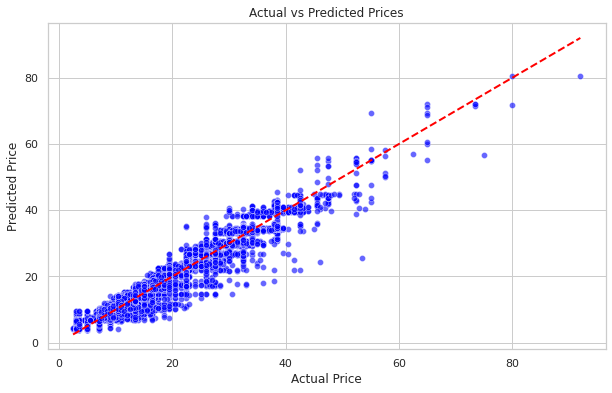

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predictions from the best model
predictions = best_model.transform(test_data)

# Sample a fraction of data if the dataset is large (optional)
sampled_predictions = predictions.sample(fraction=0.1, seed=1234)  # 10% sample

# Convert to Pandas DataFrame for plotting
actual_vs_predicted = sampled_predictions.select("price", "prediction").toPandas()

# Create a Seaborn scatterplot for actual vs predicted values
plt.figure(figsize=(10,6))
sns.scatterplot(x='price', y='prediction', data=actual_vs_predicted, alpha=0.6, color='blue')

# Add a line for perfect prediction (45-degree line)
plt.plot([min(actual_vs_predicted['price']), max(actual_vs_predicted['price'])],
         [min(actual_vs_predicted['price']), max(actual_vs_predicted['price'])],
         color='red', linestyle='--', linewidth=2)  # line of perfect prediction

# Titles and labels
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)

# Show the plot
plt.show()



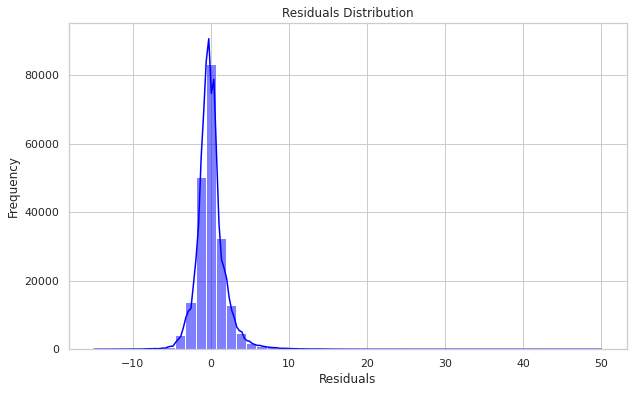

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute residuals
predictions = predictions.withColumn("residuals", predictions["price"] - predictions["prediction"])

# Convert to Pandas DataFrame for plotting
pandas_predictions = predictions.select("price", "prediction", "residuals").toPandas()

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(pandas_predictions["residuals"], bins=50, kde=True, color="blue")
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


## Summary
The **Gradient Boosted Model (GBM)** achieved an **R² of 0.95**, demonstrating strong performance in predicting Uber/Lyft Fare prices.

### - Graph Analysis:
The graph represents the relationship between Actual Prices (x-axis) and Predicted Prices (y-axis) for ride fares using the Gradient Boosted model. The red dashed line indicates a perfect 1:1 correlation (ideal predictions), while the blue dots represent the individual data points.

The model is performing well, as indicated by the centered and symmetric residuals with a narrow spread.

### - Key Observations:
The majority of the points are tightly clustered around the red line, indicating high prediction accuracy.
There are slight deviations for higher price values, where the model occasionally underestimates or overestimates, but these deviations are minimal.

### - Metrics Interpretation:
- **R-squared (R²)**: 0.95
The model explains 95% of the variance in Uber prices, showing strong predictive ability.

- **Root Mean Squared Error (RMSE)**: 1.92
On average, the predictions deviate from actual prices by about $1.92, indicating that the model’s predictions have some variance but are still relatively close to the actual values.

- **Mean Absolute Error (MAE)**: 1.28
The average absolute prediction error is $1.28, showing that, on average, the model’s predictions are off by about $1.28, which is a reasonable level of error for price prediction.

Overall, the Gradient Boosted model effectively predicts ride fares with minimal errors and significant accuracy, making it a reliable choice for fare estimation.

## Extra Credits

### 1. Extraordinary visualizations using Tableau
- Tableau dashboard is published to below link - https://public.tableau.com/views/FarePredictionProject/DataAnalysisDashboard?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link 


- **Geographic Analysis of Rides**: A map visualization shows ride locations categorized by price ranges (e.g., $0-$10, $10-$20, etc.).
-  **Ride Trends Over Time**: A line chart displays the number of trips for Uber and Lyft across the days of the week.
- **Price vs. Distance**: A histogram illustrates the relationship between ride price and distance traveled.
- **Peak Ride Hours**: A line chart highlights the busiest ride hours during the day based on the number of trips.
This dashboard enables quick comparisons of ride patterns and pricing for Uber and Lyft.


### **2. Docker (GCP)**
The following document has the screenshots showing the results from running the project in GCP using GKE

https://docs.google.com/document/d/1vNjiwCT2coxZ1FLp14fde4uebVbvDETzWO6qeHozjTY/edit?usp=sharing


GitHub Link: https://github.com/arjunghosh4/spark/tree/main/k8spark-1

### 3. Extraordinary modeling

### Feed-Forward Neural Network (FFNN) Using PyTorch

A **Feed-Forward Neural Network (FFNN)** is a type of artificial neural network where information moves in one direction — from input to output, passing through the hidden layers. It is composed of three main types of layers:
1. **Input Layer**: Accepts the features or data points.
2. **Hidden Layers**: Process the inputs using activation functions.
3. **Output Layer**: Produces the prediction or classification result.

In a FFNN, the connections between layers are fully connected, meaning every node in a layer is connected to every node in the subsequent layer. The model is trained using backpropagation, adjusting weights based on the error in predictions.

In **PyTorch**, FFNNs are implemented using the `nn.Module` class, which allows you to define the layers, forward pass, and optimization steps for training.

### Explanation of the Code

This code implements a **feed-forward neural network (FFNN)** using **PyTorch** to predict the **log-transformed price** (`log_price`) of a ride based on various features like source, destination, cab type, etc.

#### 1. **Data Preprocessing (with PySpark)**:
- **Categorical Data Handling**: 
   - The columns `source`, `destination`, `cab_type`, and `name` are categorical, so we use **`StringIndexer`** to convert them into numerical values.
- **Outlier Removal**: 
   - Outliers in the `price` column are removed based on the **1st and 99th percentiles** using `approxQuantile`.
- **Feature Engineering**: 
   - Various features like `hour`, `month`, and others are combined into a single vector using **`VectorAssembler`**.
   - The target variable (`price`) is **log-transformed** using **log** to reduce skewness and make the data more suitable for modeling.

#### 2. **Model Definition (PyTorch)**:
- The model is defined as a **feed-forward neural network (FFNN)** with three layers:
   - **Input layer**: Size based on the number of features (input dimension).
   - **Hidden layer 1**: 32 neurons.
   - **Hidden layer 2**: 16 neurons.
   - **Output layer**: 1 neuron for regression output.
- **ReLU activation** is used in the hidden layers to introduce non-linearity and help the model learn complex patterns.

#### 3. **Training**:
- **Mean Squared Error (MSE)** is used as the loss function since this is a regression problem.
- The model is trained using the **Adam optimizer**, which is an adaptive learning rate optimizer.
- **Early stopping** is implemented to halt training if the loss does not improve for a specified number of epochs.

#### 4. **Evaluation**:
- After training, the model is evaluated on the test data.
- The performance metrics used are:
   - **RMSE (Root Mean Squared Error)**: This is the average error between the predicted and actual values.
   - **R2 Score**: This indicates how well the model explains the variance in the target variable. An R2 score close to 1 means the model is a good fit.



In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log


df = spark_df  

# List of categorical columns
cat_cols = ['source', 'destination', 'cab_type', 'name']

# Apply StringIndexer only to categorical columns
for col_name in cat_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    df = indexer.fit(df).transform(df)
    df = df.drop(col_name)  # Drop original categorical columns

# Filter out extreme outliers based on 'price' column (e.g., prices above 99th percentile)
quantiles = df.approxQuantile("price", [0.01, 0.99], 0.01)
lower_bound, upper_bound = quantiles[0], quantiles[1]
df = df.filter((col("price") >= lower_bound) & (col("price") <= upper_bound))

# Define features for VectorAssembler
feature_cols = [
    'hour', 'month', 'source_index', 'destination_index', 
    'cab_type_index', 'name_index', 'distance', 
    'surge_multiplier', 'day', 'is_weekend'
]

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Log-transform target variable to reduce skewness (optional but recommended)
df = df.withColumn("log_price", log(col("price")))

# Split data into training and test sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# Convert PySpark DataFrame to numpy arrays
def dataframe_to_numpy(df, label_col, feature_col):
    labels = np.array(df.select(label_col).rdd.flatMap(lambda x: x).collect())
    features = np.array(df.select(feature_col).rdd.map(lambda row: row[0].toArray()).collect())
    return features, labels

train_features, train_labels = dataframe_to_numpy(train_data, 'log_price', 'features')
test_features, test_labels = dataframe_to_numpy(test_data, 'log_price', 'features')

# Convert to PyTorch tensors
X_train = torch.tensor(train_features, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(test_features, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.float32).view(-1, 1)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Adjust batch size as needed

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Adjust batch size as needed

# Define a simpler PyTorch model (feed-forward neural network)
class SimpleRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)  # Reduced neurons for faster execution
        self.fc2 = nn.Linear(32, 16)         # Reduced neurons
        self.fc3 = nn.Linear(16, 1)          # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
model = SimpleRegressionModel(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with fewer epochs and early stopping
epochs = 5  # Reduced epochs for faster execution
patience = 2  # Early stopping patience
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    
    # Initialize epoch loss
    epoch_loss = 0.0
    
    # Iterate over batches
    for batch_X, batch_y in train_loader:
        # Forward pass
        y_pred = model(batch_X)
        
        # Compute loss
        loss = criterion(y_pred, batch_y)
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping due to no improvement.")
            break

# Evaluate the model on test data
model.eval()
predictions = []

with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_pred = model(batch_X)
        predictions.append(batch_pred)

# Convert predictions to numpy
predictions = torch.cat(predictions).numpy().flatten()

# Calculate RMSE and R2 score manually
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

# Print metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")




Epoch 1/5, Loss: 0.2084835448321726
Epoch 2/5, Loss: 0.03745899181073935
Epoch 3/5, Loss: 0.02711541108068127
Epoch 4/5, Loss: 0.025176645025405654
Epoch 5/5, Loss: 0.023809661246497835
Root Mean Squared Error (RMSE): 0.16003462672233582
R2 Score: 0.9145526415368683


### Results:

The loss consistently decreased with each epoch, showing that the model was learning and improving over time. This gradual reduction in loss indicates effective optimization of the model's parameters.

After training, the model's performance is:
- **RMSE**: 0.1600 (average error in predictions).
- **R2 Score**: 0.9145 (indicating that the model explains 91.45% of the variance in the target variable).

The model's high **R2 score** and low **RMSE** suggest that it is a strong predictor of the target variable, and its performance can be considered quite satisfactory for this regression task.



### 4. Create ML app from PySpark

### Flask for Machine Learning Applications

**Flask** is a lightweight web framework in Python used to build APIs and web applications. For machine learning, Flask allows to deploy trained models as RESTful APIs, enabling applications to send data for predictions and receive results in real-time.

---

##### Steps:

- **Load Pre-trained Model**:
  - A `PipelineModel` is loaded from the path `file:/databricks/driver/rideshare_model` to handle both data transformation and prediction.

- **Set Up Flask Application**:
  - A Flask app is initialized to serve as the API framework.

- **Define `/predict` Endpoint**:
  - Accepts **POST** requests with input JSON data.
  - Converts the input JSON into a PySpark DataFrame.
  - Applies the loaded model to generate predictions.
  - Returns predictions in JSON format or error messages for failed requests.

- **Error Handling**:
  - Captures and returns errors as JSON responses with an HTTP 500 status code.

- **Start Flask Server**:
  - Runs the API on `host="0.0.0.0"` (external access) and `port=5000`.
  - Disables Flask’s automatic reloader for Databricks compatibility.

- **API Workflow**:
  - **Input**: Accepts feature data in JSON format.
  - **Output**: Returns predicted values as a JSON response.

This setup integrates **PySpark** for scalable model predictions and **Flask** for API deployment, making it suitable for production environments like Databricks.


In [0]:
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from flask import Flask, request, jsonify

# Initialize Spark session
spark = SparkSession.builder.appName("RideSharePrediction").getOrCreate()

# Load the model
model_path = "file:/databricks/driver/rideshare_model"
loaded_model = PipelineModel.load(model_path)
print("Model loaded successfully")

# Flask API for serving the model
app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    try:
        input_data = request.get_json()
        input_df = spark.createDataFrame([input_data])
        predictions = loaded_model.transform(input_df)
        prediction = predictions.select("prediction").collect()[0][0]
        return jsonify({"prediction": prediction})
    except Exception as e:
        return jsonify({"error": str(e)}), 500

# Start Flask server (disable reloader for Databricks compatibility)
if __name__ == "__main__":
    app.run(debug=True, host="0.0.0.0", port=5000, use_reloader=False)


Model loaded successfully
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.172.163.225:5000
Press CTRL+C to quit


### Accessing the API Endpoint and Sending a Prediction Request

On executing above Flask code, it starts a server and generates a URL (e.g., `http://10.172.163.225:5000/predict`) where the model API can be accessed. This URL allows you to send data for predictions.

---

#### Method 1: Using the API with `curl` in Databricks

To test the API, you can use the following `curl` command in a new Databricks notebook cell:

```bash
%sh
curl -X POST http://10.172.163.225:5000/predict \
-H "Content-Type: application/json" \
-d '{
    "hour": 10,
    "month": 5,
    "source_index": 1,
    "destination_index": 3,
    "cab_type_index": 0,
    "name_index": 2,
    "distance": 4.5,
    "surge_multiplier": 1.2,
    "day": 15,
    "is_weekend": 0
}'
```


#### Expected Output:
When the above command is executed, the API will return a JSON response with the predicted value. For example:
{
    "prediction": 15.67
}





#### Method 2: Using Python `requests` Library in Databricks

Alternatively, we can test the API programmatically using the Python `requests` library within a Databricks notebook. Below is the code to interact with the API:

```python
import requests
import json

# Define the API endpoint
url = "http://10.172.163.225:5000/predict"

# Define the test input data
data = {
    "hour": 10,
    "month": 5,
    "source_index": 1,
    "destination_index": 3,
    "cab_type_index": 0,
    "name_index": 2,
    "distance": 4.5,
    "surge_multiplier": 1.2,
    "day": 15,
    "is_weekend": 0
}

# Make the POST request
response = requests.post(url, json=data)

# Print the response
print(response.json())
````

#### Expected Output:
On executing the code, the API will return a JSON response similar to:
{
    "prediction": 15.67
}
